**Initial setup**

In [1]:
#! pip install --upgrade pip 
! apt -y install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8 >/dev/null 

In [2]:
! pip uninstall -y tensorflow tensorflow-gpu >/dev/null ;  
! pip uninstall -y tensorflow-io >/dev/null ; 
! pip uninstall -y tensorflow-transform >/dev/null ; 

In [3]:
! pip install tensorflow-transform >/dev/null ; 
! pip install tensorflow==2.10.1 tensorflow-gpu==2.10.1 >/dev/null ; 
! pip install keras-cv --upgrade >/dev/null ; 

**Libraries**

In [4]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

import keras_cv

print('Keras_CV : ', keras_cv.__version__)
tfk = tf.keras
tfkl = tf.keras.layers
print('Tensorflow : ', tf.__version__)

Keras_CV :  0.3.4
Tensorflow :  2.10.1


In [5]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Dataset preparation**


REF. : https://www.tensorflow.org/guide/data_performance

In [7]:
from google.colab import drive
drive.mount("/gdrive/")

Mounted at /gdrive/


In [8]:
#! unzip /gdrive/MyDrive/Dataset/dataset.zip -d /gdrive/MyDrive/annHomework1/ > /dev/null 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
datapath = '/gdrive/MyDrive/annHomework1/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)


Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


# **Dataset visualization and analysis**

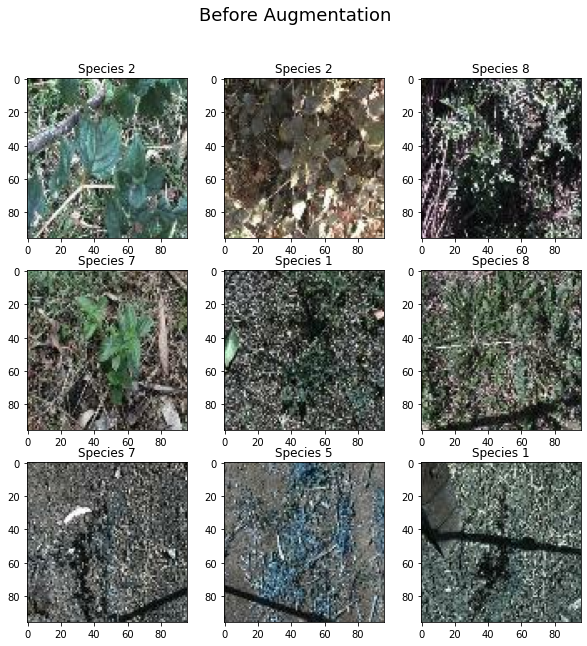

In [11]:
def visualize_dataset(dataset, title):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout(pad=7.0)

    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples[0]
        plt.subplot(3, 3, i + 1)
        idx = np.argmax(samples[1][i])+1
        plt.title(f'Species {idx}') 
        plt.imshow(images[0].numpy().astype("uint8")) 
        plt.axis("on")
    plt.show()

visualize_dataset(training_set, title="Before Augmentation")

# **Dealing with imbalance: imbalanced-learn library**

In [12]:
! pip install -U imbalanced-learn > /dev/null

**Class weights**

In [13]:
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)

{0: 2.393581081081081, 1: 0.8296252927400468, 2: 0.8923173803526449, 3: 0.843452380952381, 4: 0.8162442396313364, 5: 2.012784090909091, 6: 0.8032879818594104, 7: 0.9060102301790282}


**SMOTE**

SMOTE is a technique for generating new samples of minority classes. It exploits the closeness  among samples in the features space to synthesize new samples by means of various mathematical interpolation techniques. Several variants exist. 

We tried SVM SMOTE since we like Support Vector Machines. 
PAPER: https://arxiv.org/abs/1106.1813

NOTE: memory evictions try to keep memory footprint as low as possible since we would like to avoid crashes. 

In [14]:
from imblearn.over_sampling import SVMSMOTE #smote variant using SVMs 
smote = SVMSMOTE(sampling_strategy='not majority', random_state = 901) # we do not want to resample majority class 

images = [x  for x,y in training_set.unbatch()] 

assert len(images) == len(labels)

count = [0 for i in range(8)]
for label in labels: 
  count[np.argmax(label)]+=1 
print(count)


[148, 427, 397, 420, 434, 176, 441, 391]


In [15]:
# images are flattened before passing them to SMOTE resampler 
images_flat = []
for img in images:
  images_flat.append(tf.reshape(img, shape = 96*96*3 ))
  del img 
del images 

print(len(images_flat))
assert images_flat[0].shape == 96*96*3

2834


In [16]:
res_img, labels = smote.fit_resample(images_flat, labels)
assert len(res_img) == len(labels) 

In [17]:
images = [] 
for img in res_img: 
  images.append(tf.reshape(img, shape = (96,96,3)))
  del img 

In [18]:
del res_img

In [19]:
assert len(images) == len(labels)
print(images[0].shape)

(96, 96, 3)


In [20]:
X_train = images 
Y_train = labels 

In [21]:
count = [0 for i in range(8)]
for label in Y_train: 
  count[np.argmax(label)]+=1 
print(count)


[273, 441, 412, 426, 437, 279, 441, 419]


This type of augmentation changed dataset composition and now it is nearly balanced (numerically speaking). However, we do not know for sure why class 1 is kind of left behind.  

**Optimization**

In [25]:
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

**Preprocessing**

In [26]:
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))
X_train = tf.keras.applications.inception_v3.preprocess_input(np.asarray(X_train, dtype = np.float32))

In [27]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)

# **Network**

In [60]:
myInception = tfk.applications.inception_v3.InceptionV3(include_top = False, weights='imagenet')

In [61]:
myInception.trainable = False 

**Hyperparameters, parameters and miscellaneous**

In [62]:
input_shape = (96, 96, 3)
epochs = 100

l1 = 0.001
l2 = 0.001
dropout_rate = 0.35
###################
learning_rate = 1e-3 #TRANSFER LEARNING, training classifier only
###################

**Classifier definition**

In [63]:
# More powerful classifier to train
custom_classifier = tfk.Sequential([ 
        tfkl.Input(shape = (2048,)),
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, scale=8.0 , kernel_initializer="gaussian"),
        tfkl.Dense(units=8, 
                   activation='softmax', 
                   kernel_initializer=tfk.initializers.GlorotUniform(seed*2), 
                   name='out', 
                   kernel_regularizer = tfk.regularizers.L2(l2 = l2)                   
                   )
    ],
    name='classifier'
)

In [64]:
custom_classifier.summary() 

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_fourier_features_2 (  (None, 1024)             2098177   
 RandomFourierFeatures)                                          
                                                                 
 out (Dense)                 (None, 8)                 8200      
                                                                 
Total params: 2,106,377
Trainable params: 8,200
Non-trainable params: 2,098,177
_________________________________________________________________


**Model definition**

In [65]:
def build_model(input_shape): 
    input_layer = tfkl.Input(input_shape)
    x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
    x = myInception(x)
    x = tfkl.Dropout(rate=dropout_rate)(x)
    x = tfkl.GlobalAveragePooling2D()(x) 
    output_layer = custom_classifier(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate), metrics='accuracy')
    return model 

model = build_model(input_shape)

**Callbacks definition**

In [66]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)
    now = datetime.now().strftime('%b%d_%H-%M-%S')
    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
    callbacks = []
    
    # Model checkpoint
      # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
          
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
      
    callbacks.append(ckpt_callback)
    
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 classifier (Sequential)     (None, 8)                 2106377   
                                                             

In [68]:
MODEL_NAME = 'inception_svm' 

# **Training**

In [69]:
assert len(X_train) == len(Y_train)
assert X_train[0].shape == (96, 96 ,3)
print(len(X_train) )

3128


In [70]:
callbacks = create_folders_and_callbacks(model_name = MODEL_NAME)

history = model.fit(
    x = X_train,
    y = Y_train, 
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
).history

Epoch 1/100
98/98 [==============================] - 138s 189ms/step - loss: 2.3636 - accuracy: 0.1461 - val_loss: 2.3435 - val_accuracy: 0.1328
Epoch 2/100
98/98 [==============================] - 17s 176ms/step - loss: 2.0748 - accuracy: 0.2152 - val_loss: 2.2739 - val_accuracy: 0.1525
Epoch 3/100
98/98 [==============================] - 19s 196ms/step - loss: 1.9008 - accuracy: 0.2884 - val_loss: 2.2706 - val_accuracy: 0.1540
Epoch 4/100
98/98 [==============================] - 16s 162ms/step - loss: 1.7867 - accuracy: 0.3373 - val_loss: 2.3251 - val_accuracy: 0.1328
Epoch 5/100
98/98 [==============================] - 16s 165ms/step - loss: 1.6960 - accuracy: 0.3827 - val_loss: 2.3232 - val_accuracy: 0.1455
Epoch 6/100
98/98 [==============================] - 16s 165ms/step - loss: 1.6122 - accuracy: 0.4329 - val_loss: 2.3739 - val_accuracy: 0.1427
Epoch 7/100
98/98 [==============================] - 16s 164ms/step - loss: 1.5442 - accuracy: 0.4530 - val_loss: 2.3751 - val_accuracy

KeyboardInterrupt: ignored

In [ ]:
if not os.path.exists('models'): 
    os.mkdir('models')
os.mkdir(f'models/{MODEL_NAME}')
model.save(f"models/{MODEL_NAME}")

# **Model assessment**

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# **FINE TUNING**

# **Model loading**

In [ ]:
MODEL_NAME = 'models/inception_svm_ft' 

# **Fine tuning settings**

In [89]:
# Not a very flexible strategy but the point is this: 
# we want convergence to be reached quickly, so an high
# learning rate might fit our case. Besides that, progressively
# lowering as far as training becomes more stable might help reaching
# a good solution.

lr = 0.05
def scheduler(epoch, lr=0.05):
    if epoch < 12:
        return lr
    elif epoch < 20:
        return 0.01
    elif epoch  < 40: 
        return 0.007
    elif epoch < 60: 
        return 0.001
    else: 
        return 0.0005

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [90]:
# set up the correct learning rate 
# NOTE: if you do cutmix, use label smoothing in categorical cross entropy (see docs of CategorialCrossentropy())
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05), metrics='accuracy')

# layers setting
myInception = model.get_layer('inception_v3')
myInception.trainable = True 
for i, layer in enumerate(myInception.layers[:-1]):
    layer.trainable=True

#better safe than sorry 
for i, layer in enumerate(myInception.layers[:-1]):
    assert layer.trainable
    
myClassifier = model.get_layer('classifier')
myClassifier.trainable = True 
for i, layer in enumerate(myClassifier.layers[:-1]):
    layer.trainable=True


In [91]:
# double check 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 classifier (Sequential)     (None, 8)                 2106377   
                                                             

# **(RE)Training**

In [92]:
callbacks = create_folders_and_callbacks(model_name = MODEL_NAME)
callbacks.append(lr_callback) #adaptive learning rate 

history = model.fit(
    x = X_train,
    y = Y_train, 
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks, 
    batch_size = 64 #we tried to move to a different batch size to see if something changed
).history

Epoch 1/100
49/49 [==============================] - 21s 353ms/step - loss: 5.9259 - accuracy: 0.2168 - val_loss: 7.3919 - val_accuracy: 0.1059 - lr: 0.0500
Epoch 2/100
49/49 [==============================] - 15s 314ms/step - loss: 4.8587 - accuracy: 0.3331 - val_loss: 8.1224 - val_accuracy: 0.1497 - lr: 0.0500
Epoch 3/100
49/49 [==============================] - 15s 313ms/step - loss: 4.7446 - accuracy: 0.3350 - val_loss: 8.3515 - val_accuracy: 0.1455 - lr: 0.0500
Epoch 4/100
49/49 [==============================] - 17s 340ms/step - loss: 4.8860 - accuracy: 0.3545 - val_loss: 8.4577 - val_accuracy: 0.1299 - lr: 0.0500
Epoch 5/100
49/49 [==============================] - 16s 323ms/step - loss: 4.8436 - accuracy: 0.3581 - val_loss: 9.0540 - val_accuracy: 0.1158 - lr: 0.0500
Epoch 6/100
49/49 [==============================] - 16s 324ms/step - loss: 4.8156 - accuracy: 0.3718 - val_loss: 9.8760 - val_accuracy: 0.1229 - lr: 0.0500
Epoch 7/100
49/49 [==============================] - 16s 3

We think we might be getting something wrong in the preprocessing phase as the algorithm seem to be learning (training accuracy SLOWLY increases) but validation accuracy is even way under the accuracy of a  random classifier.

Since we could not figure out why it is so we stopped doing experiments in this direction. 

It is interesting to notice that this happened when the training pipeline changed (there no longer was a tf.data.Dataset object to hold training data).  

DISCLAIMER: what follows is pure speculation. 
A possibile explanation to this is that, maybe, we are doing SMOTE fit_resample wrong and this is disrupting our dataset to such an extent that the model learns but it learns features which do not even exist. We are still trying to debug it. 

In [93]:
# final model 
model.save(MODEL_NAME)

# **Final model assessment**

23/23 [==============================] - 3s 126ms/step - loss: 8.6408 - accuracy: 0.1836
{'loss': 8.640828132629395, 'accuracy': 0.1836158186197281}
23/23 [==============================] - 4s 129ms/step
Accuracy: 0.1836
Precision: 0.1857
Recall: 0.1783
F1: 0.1744
F1 (per class):
[0.1        0.11320755 0.16129032 0.16091954 0.24418605 0.14285714
 0.2007722  0.27230047]
WORST CLASS: Species: 1


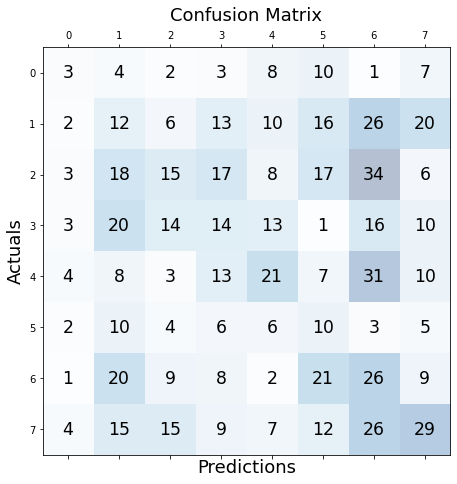

In [94]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

This experiment was a complete failure. 